In [2]:
%matplotlib ipympl

from onix.data_tools import get_experiment_data
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import data_groups
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [7]:
def gaussian(f, f_0, a, sigma, c, b):
    numerator = (f - f_0) ** 2
    denominator = 2 * sigma ** 2
    return a * np.exp(-numerator / denominator) + c + b * (f - f_0)

def get_gaussian_fit(detunings, voltages):    
    fitter = Fitter(gaussian)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    # fitter.set_p0({"a": -0.1, "sigma": 0.5, "c": 0.9})
    fitter.fit()
    
    return fitter

In [10]:
def rf_spin_echo(data_list):
    antihole_heights = []
    antihole_height_errs = []
    rf_heights = []
    rf_height_errs = []
    phases = []
    
    for kk in data_list:
        data, headers = get_experiment_data(kk)
        detunings = headers["detunings"].to("MHz").magnitude
        phases.append(headers["params"]["rf"]["phase"])
        (chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)

        # fit heights
        antihole_fit = get_gaussian_fit(detunings, antihole_avg/chasm_avg)
        antihole_heights.append(antihole_fit.results["a"])
        antihole_height_errs.append(antihole_fit.errors["a"])
        
        rf_fit = get_gaussian_fit(detunings, rf_avg/chasm_avg)
        rf_heights.append(rf_fit.results["a"])
        rf_height_errs.append(rf_fit.errors["a"])

    phases = np.array(phases)
    antihole_heights = np.array(antihole_heights)
    antihole_height_errs = np.array(antihole_height_errs)
    rf_heights = np.array(rf_heights)
    rf_height_errs = np.array(rf_height_errs)
    ratios = rf_heights / antihole_heights
    ratio_errs = ratios * np.sqrt((rf_height_errs / rf_heights) ** 2 + (antihole_height_errs / antihole_heights) ** 2)

    xs = phases
    ys = 1 - ratios
    return xs, ys
    

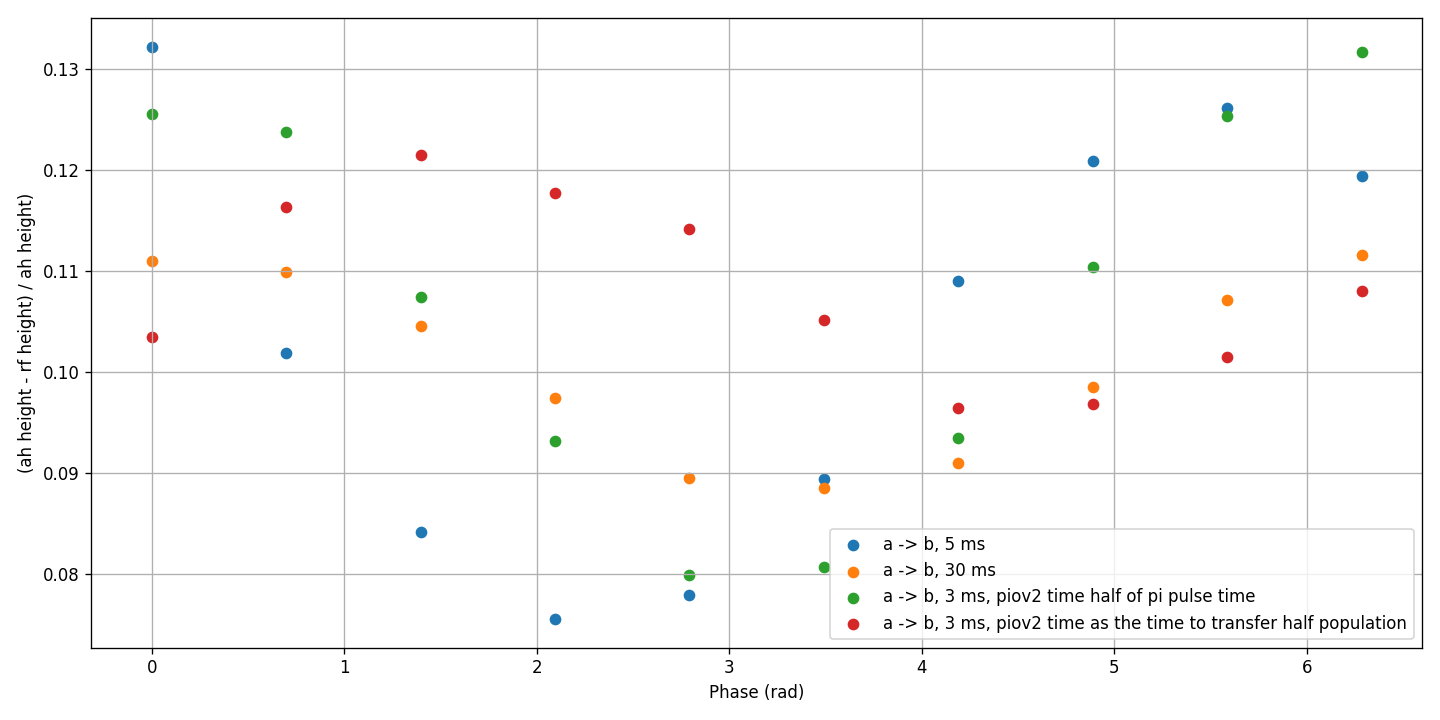

In [26]:
data = {
    "a -> b, 5 ms" : [7372, 7381],
    "a -> b, 30 ms" : [7382, 7391],
    "a -> b, 3 ms, piov2 time half of pi pulse time" : [7517, 7526],
    "a -> b, 3 ms, piov2 time as the time to transfer half population" : [7527, 7536],
}

fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)

for label, data_range in data.items():
    data_list = range(data_range[0], data_range[1]+1)
    xs, ys = rf_spin_echo(data_list)
    ax.scatter(xs, ys, label = label)
    
ax.set_xlabel("Phase (rad)")
ax.set_ylabel("(ah height - rf height) / ah height)")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

In [1168]:
data, headers = get_experiment_data(6120)

In [1169]:
(chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)
detunings_MHz = headers["detunings"].to("MHz").magnitude

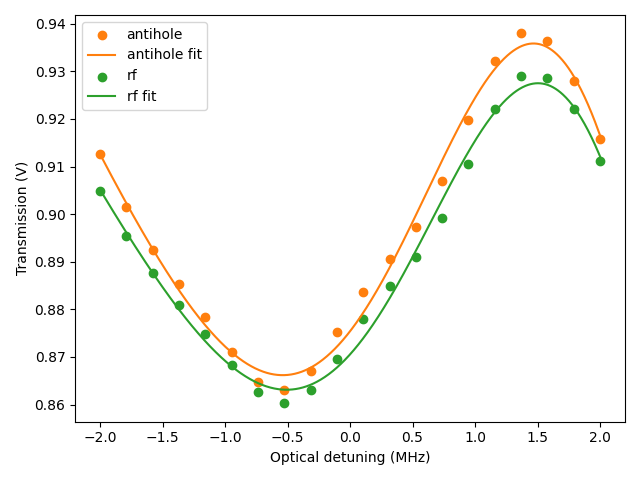

0.22681766827965508
0.025577569997439983
1.2512966384170672
0.08289134752039415


In [1170]:
plt_monitor = False

antihole_normalized = antihole_avg/chasm_avg
rf_normalized = rf_avg/chasm_avg

fig, ax = plt.subplots()
# ax.scatter(detunings_MHz, chasm_avg, label="chasm", color="C0")
ax.scatter(detunings_MHz, antihole_normalized, label="antihole", color="C1")

antihole_fit = get_gaussian_fit(detunings_MHz, antihole_normalized)
xaxis = np.linspace(min(detunings_MHz), max(detunings_MHz), 1000)
ax.plot(xaxis, antihole_fit.fitted_value(xaxis), label = "antihole fit", color="C1")

if "rf_repeats" in headers["params"]["detect"]:
    ax.scatter(detunings_MHz, rf_normalized, label="rf", color="C2")
    #ax.scatter(detunings_MHz, np.average(rf_avg, axis=0) / np.average(antihole_avg, axis=0), label="rf / antihole")

    rf_fit = get_gaussian_fit(detunings_MHz, rf_normalized)
    ax.plot(xaxis, rf_fit.fitted_value(xaxis), label = 'rf fit', color="C2")
            
ax.set_xlabel("Optical detuning (MHz)")
ax.set_ylabel("Transmission (V)")
plt.legend()
plt.tight_layout()
plt.show()

print(antihole_fit.results["a"])
print(antihole_fit.errors["a"])
print(antihole_fit.results["sigma"])
print(antihole_fit.errors["sigma"])